# Import Libraries

In [27]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy.optimize as sciOp
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
import warnings
from tqdm import trange
from matplotlib import cm

# Initialize Parameters

In [28]:
#### Grid Parameters
TE_array = np.arange(8, 513, 8) #ms units

#### Model parameters
c1 = 0.4
c2 = 0.6
T21 = 75
T22 = 80
T11 = 150
T12 = 450

true_params = np.array([T11, T12, c1, c2, T21, T22])

param_list = ["T11", "T12", "c1", "c2", "T21", "T22"]

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#Bound used during NLLS to constrain the upper bound on T2 values
T1_bound = 1500
T2_bound = 300

#### Process parameters
SNR_fixed = 1000        #This is the default SNR value
num_iters = 1          #This is how many noisey repitions are used for each TI value
num_starts = 1         #For each iteration, this many starts are used to determine the best parameters - the best answer here for the monoexponential is 2

round_params = [round(num, 2) for num in true_params]
pList = ', '.join(str(x) for x in round_params)
pTitleList = ', '.join(x for x in param_list)

details = (f"\nNull Point SNR = {SNR_fixed} \nNum fminbnd Repetitions = {num_iters} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

print(f'TI1* null point {TI1star}')
print(f'TI2* null point {TI2star}')

TI1* null point 103.97207708399179
TI2* null point 311.9162312519754


# Initialize Functions

### General Functions

In [29]:
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_5p_ravel(T_dat, T11, c1, d2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

def S_moX_3p(T_dat, c, T1, T2):
    TE, TI = T_dat
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

def add_noise(data, SNR):
    sigma = np.max(np.abs(data))/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    return data + noise

def get_func_bounds(function):
    f_name = function.__name__
    if f_name == "S_biX_4p":
        lower_bound = (-1,-1,0,0)
        upper_bound = (1,1,300,300)
    elif f_name == "S_moX_2p":
        lower_bound = (-1,0)
        upper_bound = (1,300)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name == "S_biX_4p":
        params = ("d1","d2","T21","T22")
    elif f_name == "S_moX_2p":
        params = ("d","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(lb, ub, func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        f_name = func.__name__
        if f_name.find("moX") > -1:
            p0 = [0,80]
        elif f_name.find("biX") > -1:
            p0 = [0,0,60,80]
        else:
            p0 = true_params
            
    return p0

def calc_MSE(paramStore, true_params, clipped = False):
    varMat = np.var(paramStore,axis=0)
    biMat = np.mean(paramStore - true_params ,axis=0)
    MSEMat = varMat + biMat**2
    if clipped:
        return MSEMat[-4:], biMat[-4:], varMat[-4:]
    return MSEMat, biMat, varMat

### Process Functions

In [30]:
def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def estimate_NLLS(func, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(func, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    popt = check_param_order(popt, func)
        
    return popt

def generate_noised_sigs(TI, tdata, SNR = SNR_fixed, params = true_params, iterations = num_iters, seed_val = rand_seed):
    
    noised_ensemble = np.zeros((iterations,np.size(tdata)))
    for iter in range(iterations):
        # np.random.seed(seed_val+iter)
        true_sig = S_biX_6p(tdata, TI, *params)
        noised_sig = add_noise(true_sig, SNR)
        noised_ensemble[iter,:] = noised_sig
    return noised_ensemble

def multistart_estimate_NLLS(func, tdata, noisey_sig, lb, ub, starts = num_starts):
    best_RSS = np.inf
    best_params = [] 
    for start in range(starts):
        init_p = set_p0(lb, ub, func) #This should almost always be a random initial starting location
        hold_popt = estimate_NLLS(func, tdata, noisey_sig, init_p, lb, ub)
        recreated_curve = func(tdata, *hold_popt)
        recreated_curves_RSS = np.sum((noisey_sig - recreated_curve)**2)

        if recreated_curves_RSS < best_RSS:
            best_RSS = recreated_curves_RSS
            best_params = hold_popt
        
    return best_params, best_RSS

def logical_estimation(TI1st, TI2st, SNR_level = SNR_fixed):
    guess_T11 = TI1st/np.log(2)
    guess_T12 = TI2st/np.log(2)

    lb, ub = get_func_bounds(S_moX_2p)

    data_np1 = np.squeeze(generate_noised_sigs(TI1st, TE_array, SNR = SNR_level))
    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np1, lb, ub)
    guess_d2 = best_params[0]
    guess_T22 = best_params[1]

    guess_c2 = guess_d2 / (1 - 2*np.exp(-TI1st/guess_T12))

    data_np2 = np.squeeze(generate_noised_sigs(TI2st, TE_array, SNR = SNR_level))
    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np2, lb, ub)
    guess_d1 = best_params[0]
    guess_T21 = best_params[1]

    guess_c1 = guess_d1 / (1 - 2*np.exp(-TI2st/guess_T11))

    guess_params = [guess_T11, guess_T12, guess_c1, guess_c2, guess_T21, guess_T22]

    return guess_params

def logical_estimation_curve(TI1st, TI2st, data_np1, data_np2):
    guess_T11 = TI1st/np.log(2)
    guess_T12 = TI2st/np.log(2)

    lb, ub = get_func_bounds(S_moX_2p)

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np1, lb, ub)
    guess_d2 = best_params[0]
    guess_T22 = best_params[1]

    guess_c2 = guess_d2 / (1 - 2*np.exp(-TI1st/guess_T12))

    best_params, best_RSS = multistart_estimate_NLLS(S_moX_2p, TE_array, data_np2, lb, ub)
    guess_d1 = best_params[0]
    guess_T21 = best_params[1]

    guess_c1 = guess_d1 / (1 - 2*np.exp(-TI2st/guess_T11))

    guess_params = [guess_T11, guess_T12, guess_c1, guess_c2, guess_T21, guess_T22]

    return guess_params

### Plotting Functions

In [32]:
def get_hist_index(param_label):
    if param_label[-1] == '2':
        row = 1
    else:
        row = 0

    if param_label[:-1] == "T1":
        col = 0
        if param_label[-1] == '2':
            row = 0
        else:
            row = 1
    elif param_label[:-1] == "c":
        col = 1
    else:
        col = 2

    return row, col

def parameter_histogram(paramStore, true_params, labels, add_title):
    fig, ax = plt.subplots(2, 3, figsize=(12,5.5), tight_layout=True)
    fig.suptitle(add_title + details)

    MSEMat, _, _ = calc_MSE(paramStore, true_params)

    for ii in range(paramStore.shape[1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        ax[row, col].hist(x=paramStore[:,ii], bins=20, color='b', label = labels[ii], alpha = 0.7)
        ax[row, col].set_xlabel('Param Value')
        ax[row, col].set_ylabel('Count')
        ax[row, col].axvline(x=true_params[ii], linewidth=1, label= 'True ' + labels[ii], color='black')
        ax[row, col].axvline(x=np.mean(paramStore[:,ii]), linewidth=1, label= 'Avg ' + labels[ii], color='red', ls = "--")
        ax[row, col].legend()
        ax[row, col].set_title('True ' + labels[ii] + '=' + "{:.2e}".format(true_params[ii]) + 
                    # '\nVar(' + paramTitle_6p[2*ii] + ') = ' +"{:.2e}".format(varMat[2*ii]) + 
                    # '\nBias(' + paramTitle_6p[2*ii] + ') = ' + "{:.2e}".format(biMat[2*ii]) + 
                    '\nMSE(' + labels[ii] + ') = ' + "{:.2e}".format(MSEMat[ii]))
    plt.show()
    return

def parameter_deltaPlot(delta_array, param_metric, labels, add_title, deets = "", xlab = 'Delta Value', ylab = 'Metric', pos = True):
    fig, ax = plt.subplots(2, 3, figsize=(12,5.5), tight_layout=True)
    fig.suptitle(add_title + deets)

    max_array = np.zeros(3)
    if pos:
        max_array[0] = np.max(param_metric[:,0:2])
        max_array[1] = np.max(param_metric[:,2:4])
        max_array[2] = np.max(param_metric[:,4:])
        min_array = [0,0,0]
    else:
        max_array[0] = np.max(np.abs(param_metric[:,0:2]))
        max_array[1] = np.max(np.abs(param_metric[:,2:4]))
        max_array[2] = np.max(np.abs(param_metric[:,4:]))
        min_array = -1*max_array


    for ii in range(param_metric.shape[-1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        ax[row, col].plot(delta_array, param_metric[:,ii], )
        ax[row, col].set_xlabel(xlab)
        ax[row, col].set_ylabel(ylab)
        ax[row, col].set_ylim([min_array[col],max_array[col]])
        ax[row, col].set_title(f"{labels[ii]}")
    plt.show()
    return

def parameter_deltaPlot_2d(delta_array, param_metric, labels, add_title, deets = "", xlab = 'Delta Value on TI2*', ylab = 'Delta Value on TI2*', pos = True):
    fig, ax = plt.subplots(2, 3, figsize=(12,7), tight_layout=True)
    fig.suptitle(add_title + deets)

    max_array = np.zeros(3)
    if pos:
        max_array[0] = np.max(param_metric[:,:,0:2])
        max_array[1] = np.max(param_metric[:,:,2:4])
        max_array[2] = np.max(param_metric[:,:,4:])
        min_array = [0,0,0]
    else:
        max_array[0] = np.max(np.abs(param_metric[:,:,0:2]))
        max_array[1] = np.max(np.abs(param_metric[:,:,2:4]))
        max_array[2] = np.max(np.abs(param_metric[:,:,4:]))
        min_array = -1*max_array

    for ii in range(param_metric.shape[-1]):

        row, col = get_hist_index(labels[ii])
        #Construct a nice figure of each of the two 
        imc = ax[row, col].imshow(param_metric[:,:,ii], cmap = 'jet')#, vmin = min_array[col], vmax = max_array[col])
        ax[row, col].set_xlabel(xlab)
        ax[row, col].set_ylabel(ylab)
        ax[row, col].set_xticks(np.arange(len(delta_array)))
        ax[row, col].set_yticks(np.arange(len(delta_array)))
        ax[row, col].set_xticklabels(delta_array)
        ax[row, col].set_yticklabels(delta_array)
        original_labels = [np.round(label,2) for label in delta_array]
        labels_of_interest = [np.round(delta_array[i],2) for i in np.arange(0,delta_array.shape[0],5)]
        new_labels = [label if label in labels_of_interest else "" for label in original_labels]
        ax[row, col].set_xticklabels(new_labels, rotation=-45)
        ax[row, col].set_yticklabels(new_labels)
        ax[row, col].set_title(f"{labels[ii]}")
        plt.colorbar(imc, ax=ax[row, col], fraction=0.046, pad=0.04)
    plt.show()
    return


### Delta Experiments

##### Delta - Bias

In [ ]:
### We are starting with known parameter values 
# c1 = 0.4
# c2 = 0.6
# T21 = 45
# T22 = 100
# T11 = 600
# T12 = 1200

#We are going to take a single null point and perturb it by a certain amount - assume the other null point is known perfectly
#Then estimate the parameter fit n times and evaluate the parameter variance in all other parameters

delta_bias_range = np.linspace(-5,5,21)
noisey_reps = 80
SNR_est = 10**10
np.random.seed(6)

details_delta = (f"\nNull Point SNR = {SNR_est} :: Noisey Repetitions = {noisey_reps}\nNum Points = {delta_bias_range.shape[0]} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

delta_bias_1p = np.zeros((delta_bias_range.shape[0], noisey_reps, 6))

for iDelt in trange(delta_bias_range.shape[0]):
    for iNR in range(noisey_reps):
        delta_bias_1p[iDelt,iNR,:] = logical_estimation(TI1star+delta_bias_range[iDelt], TI2star, SNR_level = SNR_est)



100%|██████████| 21/21 [00:33<00:00,  1.60s/it]


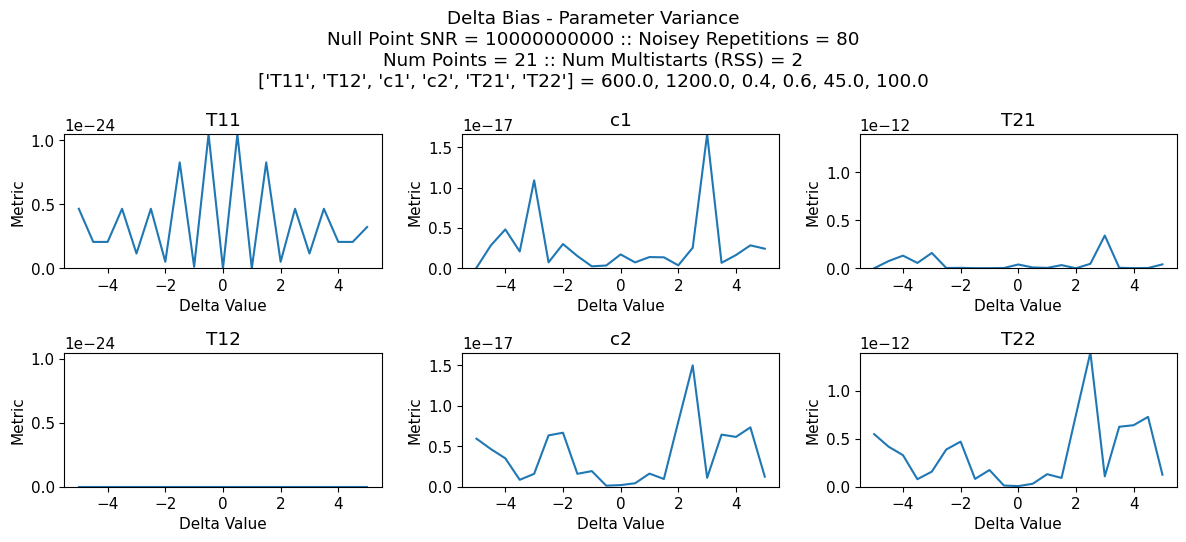

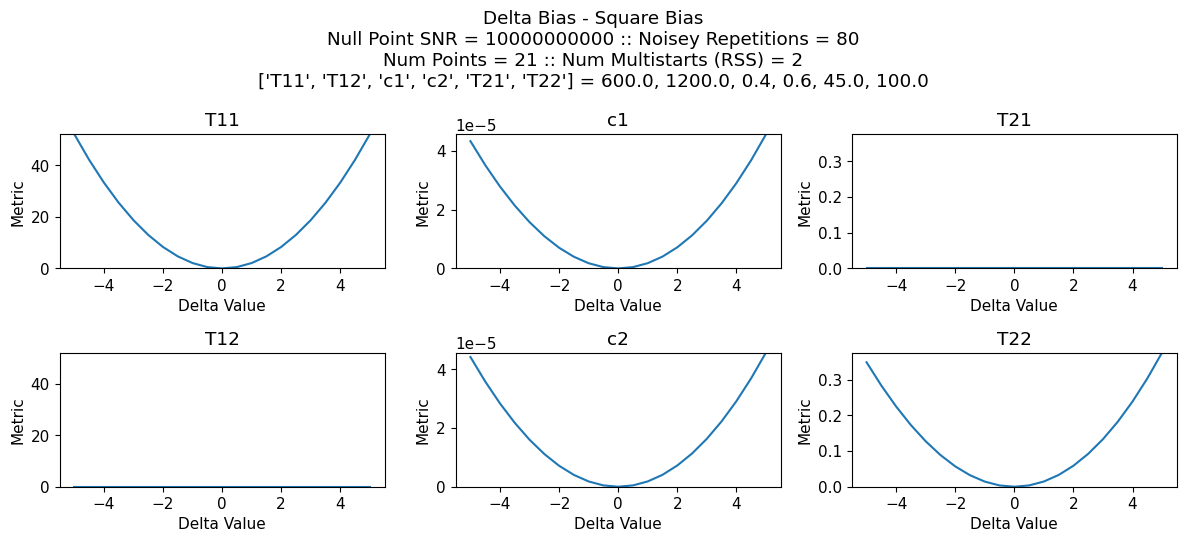

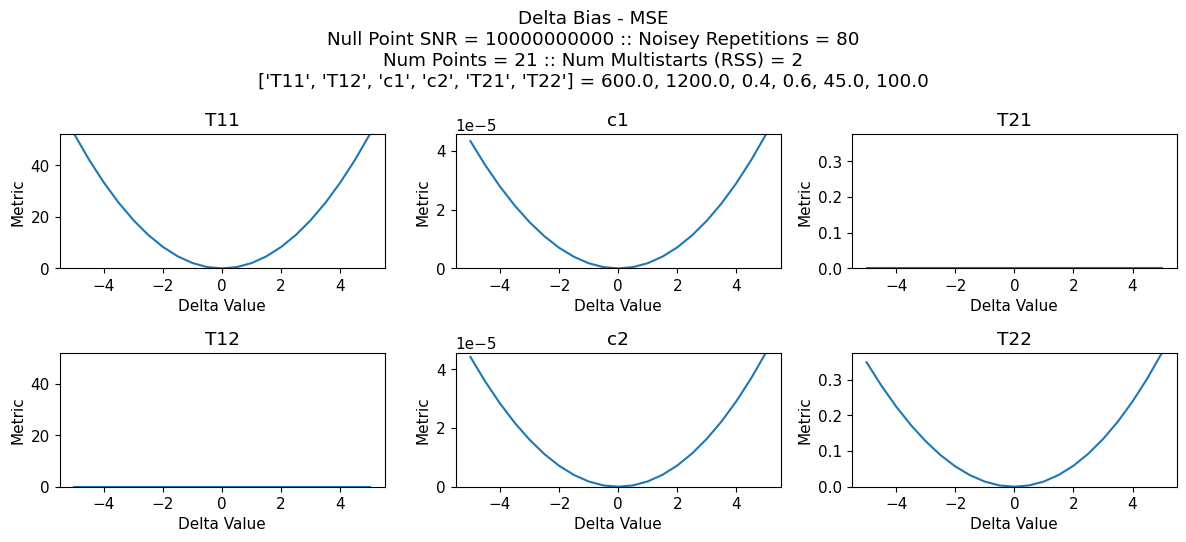

In [ ]:
delta_bias_1p_var = np.var(delta_bias_1p, axis = 1)
delta_bias_1p_mean = np.mean(delta_bias_1p, axis = 1)
# delta_bias_1p_bias = delta_bias_1p_mean - true_params
delta_bias_1p_bias = np.mean(delta_bias_1p - true_params, axis = 1)
delta_bias_1p_MSE = delta_bias_1p_bias**2 + delta_bias_1p_var

delta_bias_1p_CV1 = delta_bias_1p_var/delta_bias_1p_mean
delta_bias_1p_CV2 = delta_bias_1p_var/true_params

plt.rc('font', size  = 11)

parameter_deltaPlot(delta_bias_range, delta_bias_1p_var, param_list, "Delta Bias - Parameter Variance", deets = details_delta)

parameter_deltaPlot(delta_bias_range, delta_bias_1p_bias**2, param_list, "Delta Bias - Square Bias", deets = details_delta)

parameter_deltaPlot(delta_bias_range, delta_bias_1p_MSE, param_list, "Delta Bias - MSE", deets = details_delta)

# parameter_deltaPlot(delta_bias_range, delta_bias_1p_CV1, param_list, "Delta Bias - CV - Sample Mean", deets = details_delta)

# parameter_deltaPlot(delta_bias_range, delta_bias_1p_CV2, param_list, "Delta Bias - CV - True Value", deets = details_delta)

In [ ]:
delta_bias_2p = np.zeros((delta_bias_range.shape[0], delta_bias_range.shape[0], noisey_reps, 6))

for iDelt in trange(delta_bias_range.shape[0]):
    for jDelt in range(delta_bias_range.shape[0]):
        for iNR in range(noisey_reps):
            delta_bias_2p[iDelt, jDelt, iNR, :] = logical_estimation(TI1star+delta_bias_range[iDelt], TI2star+delta_bias_range[jDelt], SNR_level = SNR_est)


 10%|▉         | 2/21 [01:21<12:54, 40.76s/it]


KeyboardInterrupt: 

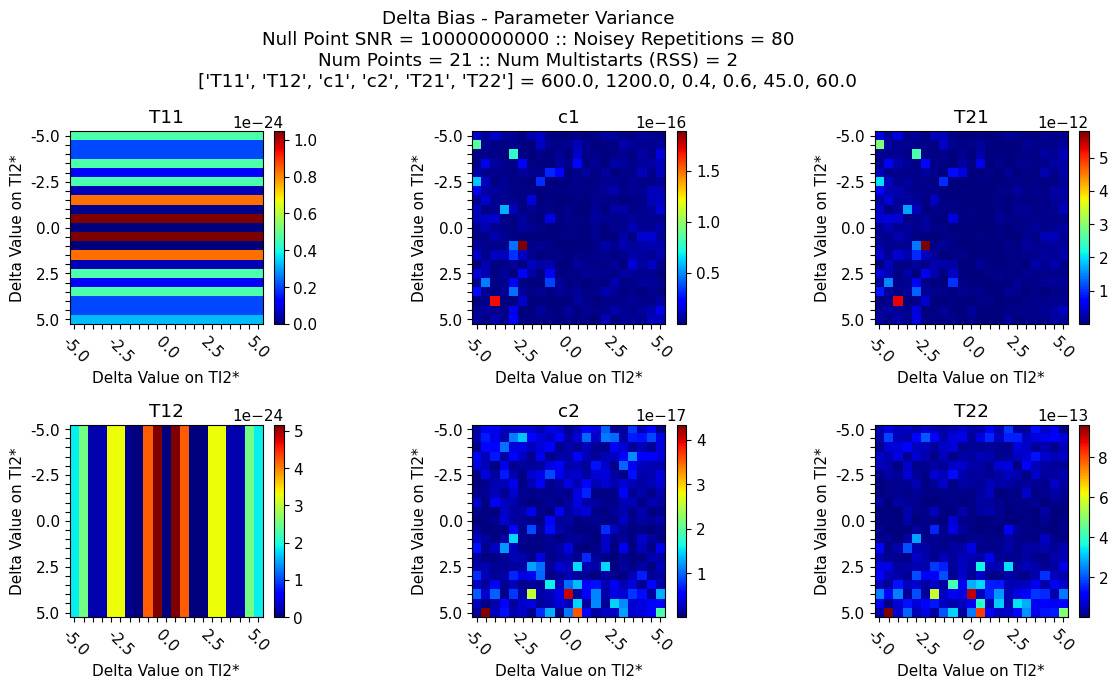

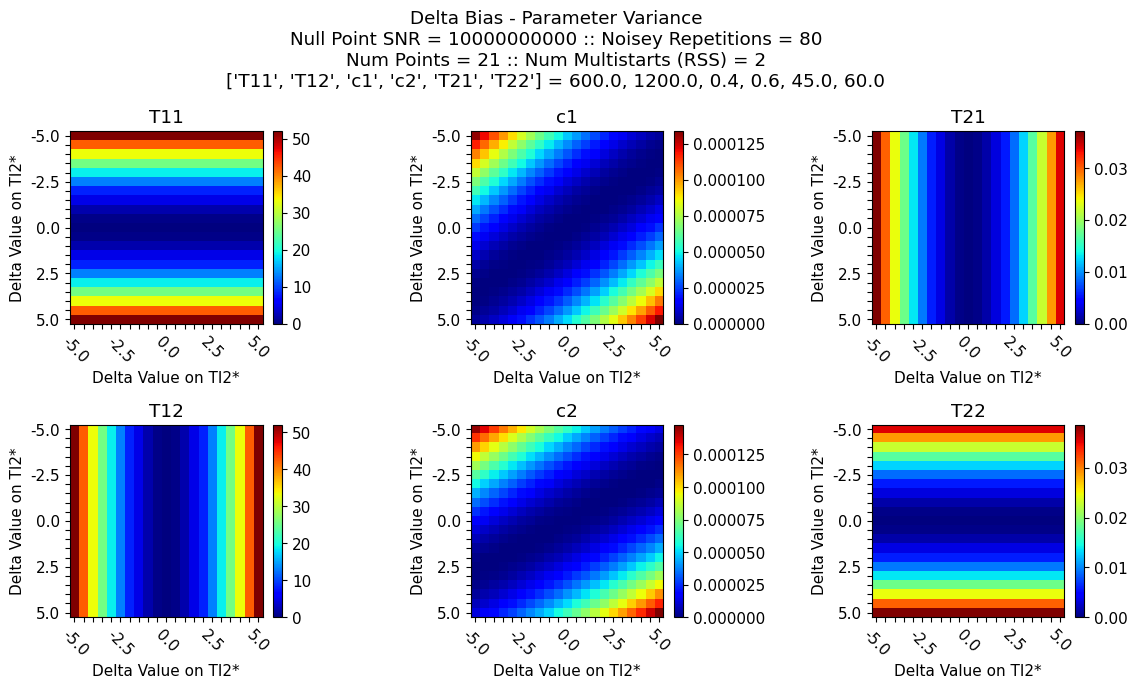

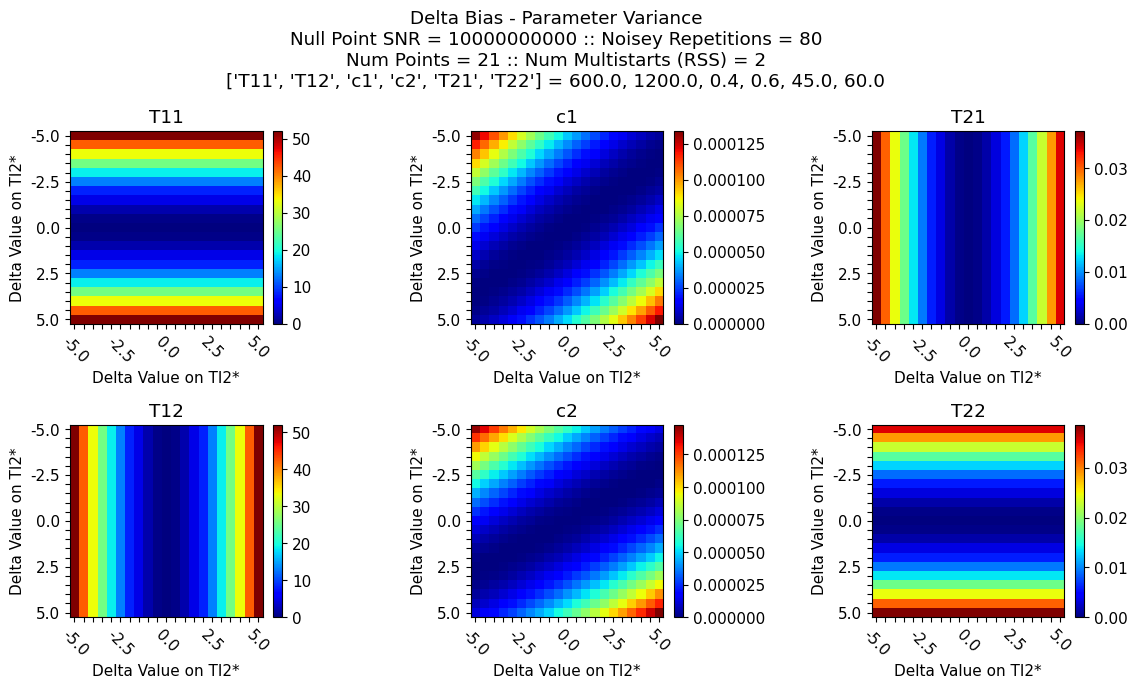

In [ ]:
delta_bias_2p_var = np.var(delta_bias_2p, axis = -2)
delta_bias_2p_mean = np.mean(delta_bias_2p, axis = -2)
# delta_bias_2p_bias = delta_bias_2p_mean - true_params
delta_bias_2p_bias = np.mean(delta_bias_2p - true_params, axis = -2)
delta_bias_2p_MSE = delta_bias_2p_bias**2 + delta_bias_2p_var

delta_bias_2p_CV1 = delta_bias_2p_var/delta_bias_2p_mean
delta_bias_2p_CV2 = delta_bias_2p_var/true_params

parameter_deltaPlot_2d(delta_bias_range, delta_bias_2p_var, param_list, "Delta Bias - Parameter Variance", deets = details_delta)

parameter_deltaPlot_2d(delta_bias_range, delta_bias_2p_bias**2, param_list, "Delta Bias - Parameter Variance", deets = details_delta)

parameter_deltaPlot_2d(delta_bias_range, delta_bias_2p_MSE, param_list, "Delta Bias - Parameter Variance", deets = details_delta)


##### Delta - Variance

In [ ]:
### We are starting with known parameter values 
# c1 = 0.4
# c2 = 0.6
# T21 = 45
# T22 = 100
# T11 = 600
# T12 = 1200

#We are going to take a single null point and perturb it by a certain amount - assume the other null point is known perfectly
#Then estimate the parameter fit n times and evaluate the parameter variance in all other parameters

delta_var_range = np.linspace(0,2,21)
noisey_reps = 100
SNR_est = 1000

delta_var_1p = np.zeros((delta_var_range.shape[0], noisey_reps, 6))

details_delta_var = (f"\nNull Point SNR = {SNR_est} :: Noisey Repetitions = {noisey_reps}\nNum Points = {delta_var_range.shape[0]} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

for iDelt in trange(delta_var_range.shape[0]):
    for iNR in range(noisey_reps):
        delt = np.random.normal(0,delta_var_range[iDelt])
        delta_var_1p[iDelt,iNR,:] = logical_estimation(TI1star+delt, TI2star, SNR_level = SNR_est)

100%|██████████| 21/21 [01:45<00:00,  5.02s/it]


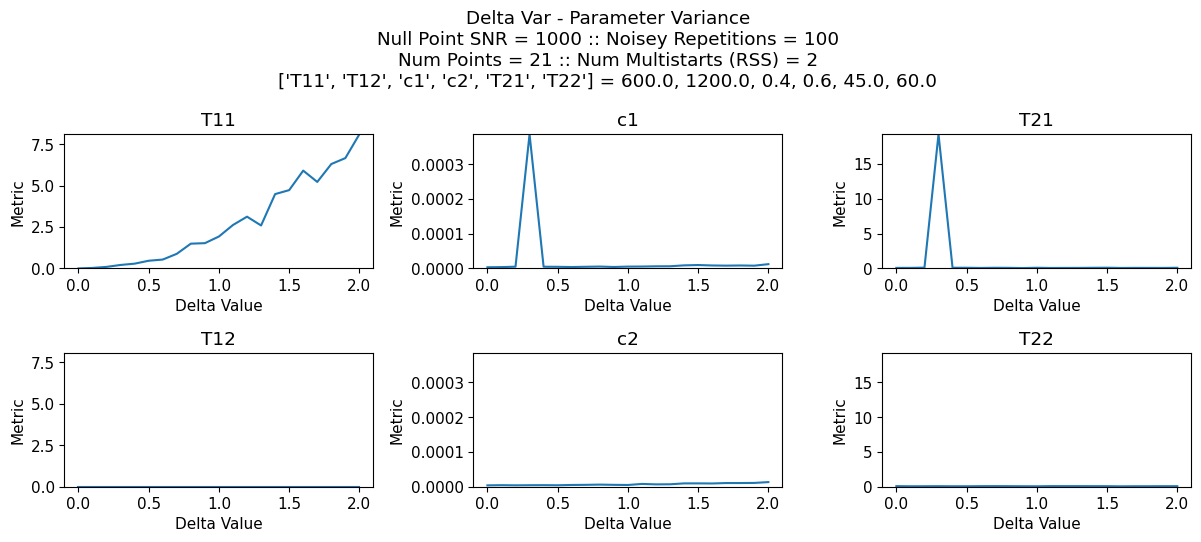

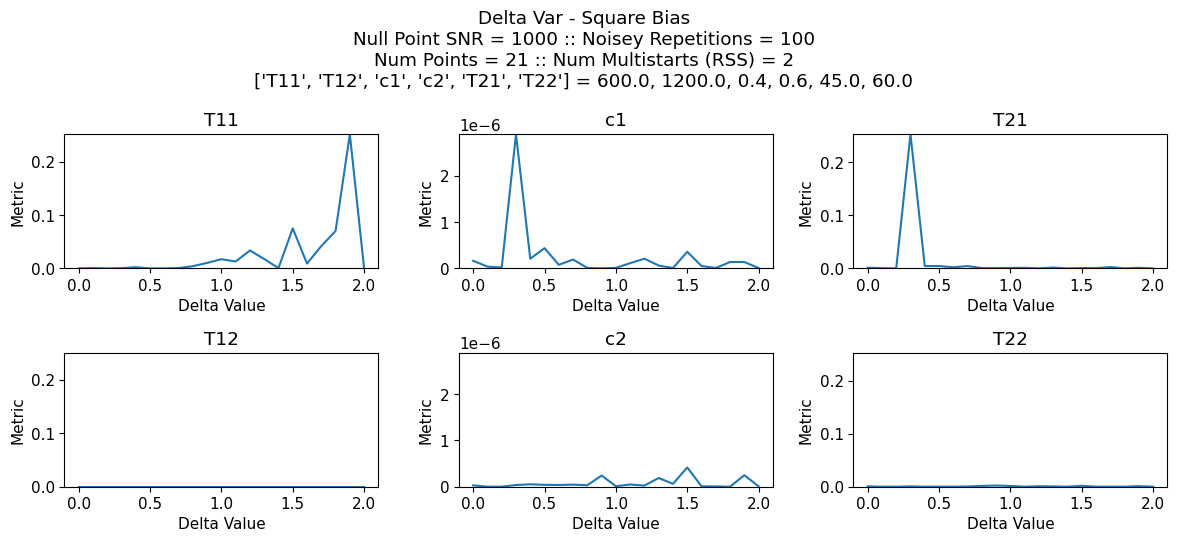

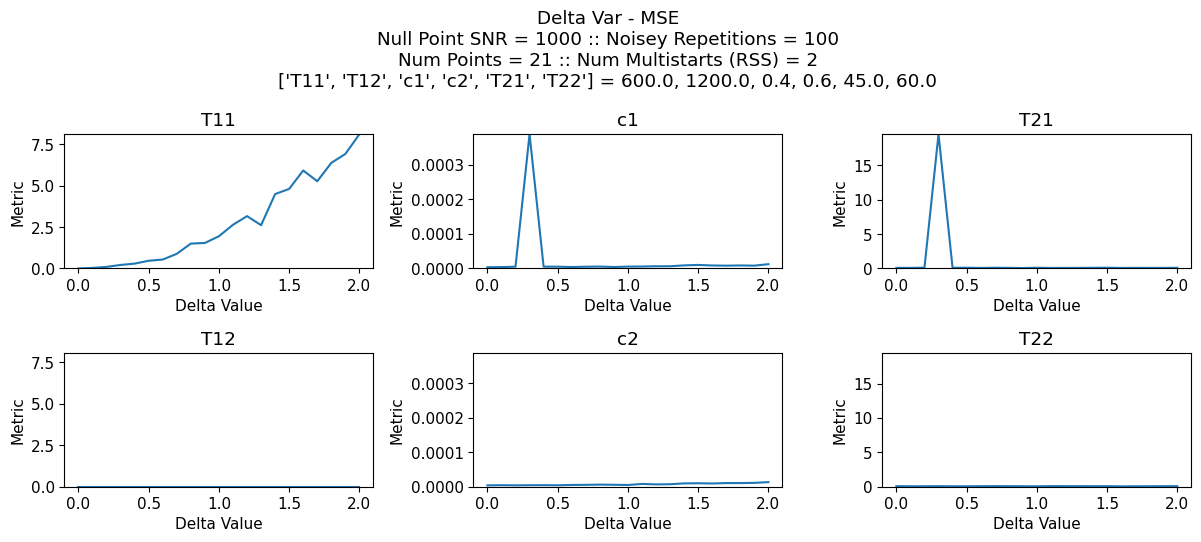

In [ ]:
delta_var_1p_var = np.var(delta_var_1p, axis = 1)
delta_var_1p_mean = np.mean(delta_var_1p, axis = 1)
# delta_var_1p_bias = delta_var_1p_mean - true_params
delta_var_1p_bias = np.mean(delta_var_1p - true_params, axis = 1)

delta_var_1p_CV1 = delta_var_1p_var/delta_var_1p_mean
delta_var_1p_CV2 = delta_var_1p_var/true_params

plt.rc('font', size  = 11)

parameter_deltaPlot(delta_var_range, delta_var_1p_var, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)

parameter_deltaPlot(delta_var_range, delta_var_1p_bias**2, param_list, "Delta Var - Square Bias", deets = details_delta_var)

parameter_deltaPlot(delta_var_range, delta_var_1p_bias**2 + delta_var_1p_var, param_list, "Delta Var - MSE", deets = details_delta_var)

# parameter_deltaPlot(delta_var_range, delta_var_1p_CV1, param_list, "Delta Var - CV - Sample Mean", deets = details_delta)

# parameter_deltaPlot(delta_var_range, delta_var_1p_CV2, param_list, "Delta Var - CV - True Value", deets = details_delta)

In [ ]:
delta_var_2p = np.zeros((delta_var_range.shape[0], delta_var_range.shape[0], noisey_reps, 6))

for iDelt in trange(delta_var_range.shape[0]):
    for jDelt in range(delta_var_range.shape[0]):
        for iNR in range(noisey_reps):
            delt_i = np.random.normal(0,delta_var_range[iDelt])
            delt_j = np.random.normal(0,delta_var_range[jDelt])
            delta_var_2p[iDelt, jDelt, iNR, :] = logical_estimation(TI1star+delt_i, TI2star+delt_j, SNR_level = SNR_est)


 48%|████▊     | 10/21 [16:03<17:25, 95.01s/it]

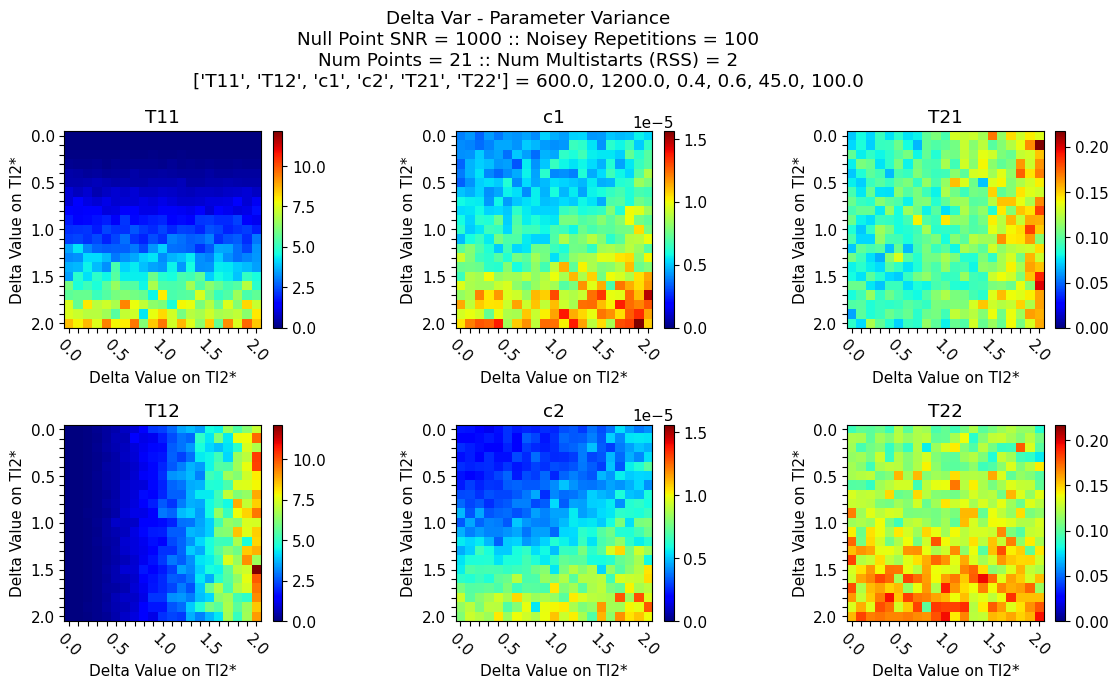

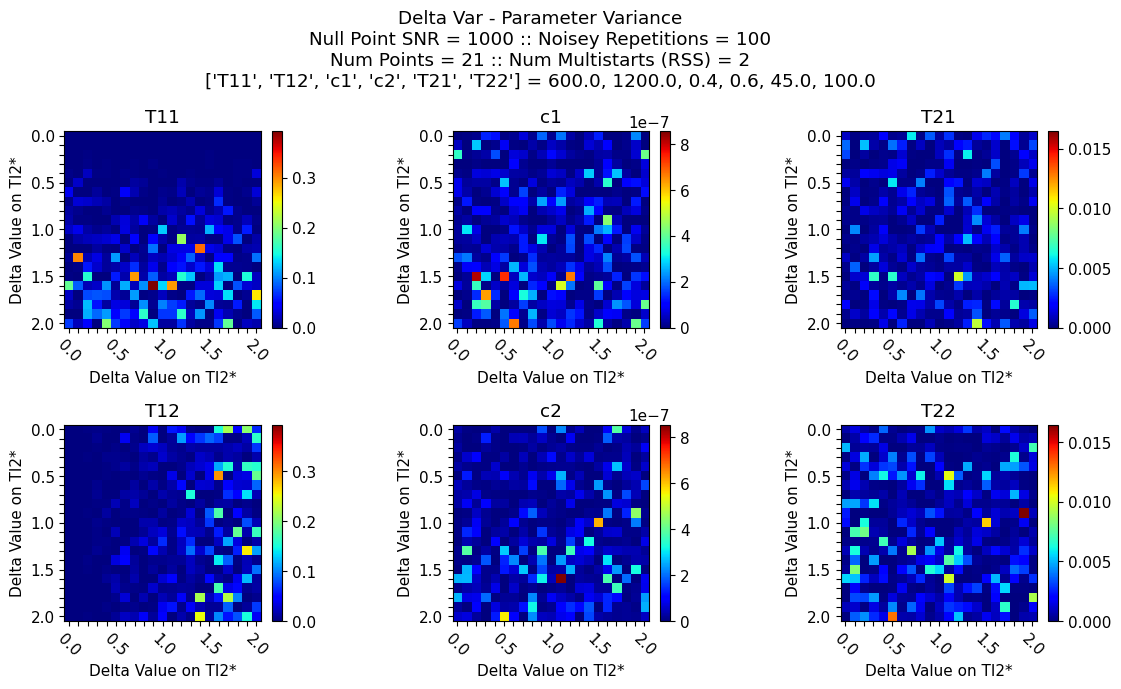

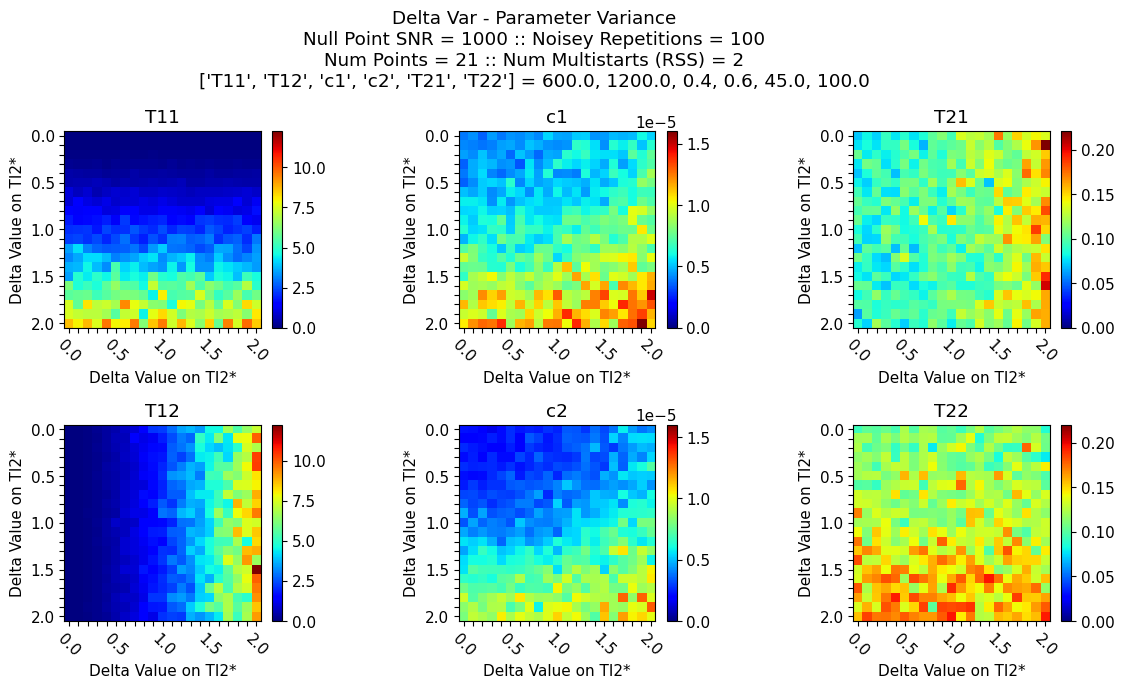

In [ ]:
delta_var_2p_var = np.var(delta_var_2p, axis = -2)
delta_var_2p_mean = np.mean(delta_var_2p, axis = -2)
# delta_var_2p_bias = delta_var_2p_mean - true_params
delta_var_2p_bias = np.mean(delta_var_2p - true_params, axis = -2)
delta_var_2p_MSE = delta_var_2p_bias**2 + delta_var_2p_var

delta_var_2p_CV1 = delta_var_2p_var/delta_var_2p_mean
delta_var_2p_CV2 = delta_var_2p_var/true_params

parameter_deltaPlot_2d(delta_var_range, delta_var_2p_var, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)

parameter_deltaPlot_2d(delta_var_range, delta_var_2p_bias**2, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)

parameter_deltaPlot_2d(delta_var_range, delta_var_2p_MSE, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)


##### Noiseless Case

In [48]:
# exact_data_np1 = S_moX_3p((TE_array, TI1star), c2, T12, T22)
# exact_data_np2 = S_moX_3p((TE_array, TI2star), c1, T11, T21)

# fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
# ax[0].plot(TE_array, exact_data_np1, marker = 'o', color = 'k')
# ax[0].set_title(f'Null Point 1: TI = TI1* = {TI1star}')
# ax[0].set_xlabel('TE')
# ax[0].set_ylabel('Signal')
# ax[1].plot(TE_array, exact_data_np2, marker = 'o', color = 'k')
# ax[0].set_title(f'Null Point 2: TI = TI2* = {TI2star}')
# ax[0].set_xlabel('TE')
# ax[0].set_ylabel('Signal')

delta_NN_range_rel = np.linspace(-0.1,0.1,21)
noisey_reps = 40
np.random.seed(6)

details_delta_NN = (f"\nNoiseless Case :: Repetitions = {noisey_reps}\nNum Points = {delta_NN_range_rel.shape[0]} :: Num Multistarts (RSS) = {num_starts}" + 
           f"\n{param_list} = {pList}")

#NN for No Noise
delta_NN_1p = np.zeros((delta_NN_range_rel.shape[0], noisey_reps, 6))

for iDelt in trange(delta_NN_range_rel.shape[0]):
    for iNR in range(noisey_reps):
        delta_change = delta_NN_range_rel[iDelt]*TI2star
        T1_focus = TI1star#+delta_change
        T2_focus = TI2star+delta_change
        exact_data_np1 = S_biX_6p(TE_array, T1_focus, T11, T12, c1, c2, T21, T22)
        exact_data_np2 = S_biX_6p(TE_array, T2_focus, T11, T12, c1, c2, T21, T22)
        delta_NN_1p[iDelt,iNR,:] = logical_estimation_curve(T1_focus, T2_focus, exact_data_np1, exact_data_np2)


100%|██████████| 21/21 [01:54<00:00,  5.45s/it]


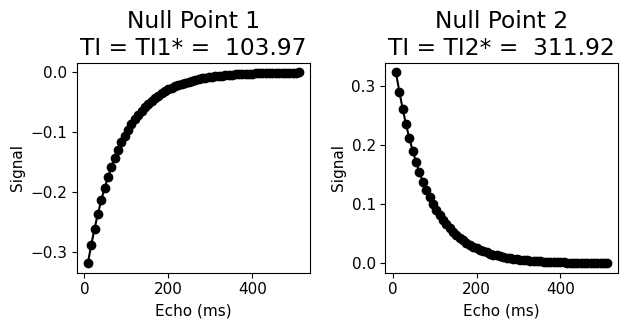

In [49]:
fig, ax = plt.subplots(1,2, figsize=(6.5,3.5), tight_layout=True)
plt.rc('font', size = 14)
ax[0].plot(TE_array, exact_data_np1, marker = 'o', color = 'k')
ax[0].set_title(f'Null Point 1\nTI = TI1* = {TI1star: 0.2f}')
ax[0].set_xlabel('Echo (ms)')
ax[0].set_ylabel('Signal')
ax[1].plot(TE_array, exact_data_np2, marker = 'o', color = 'k')
ax[1].set_title(f'Null Point 2\nTI = TI2* = {TI2star: 0.2f}')
ax[1].set_xlabel('Echo (ms)')
ax[1].set_ylabel('Signal')
plt.show()
plt.rc('font', size = 11)

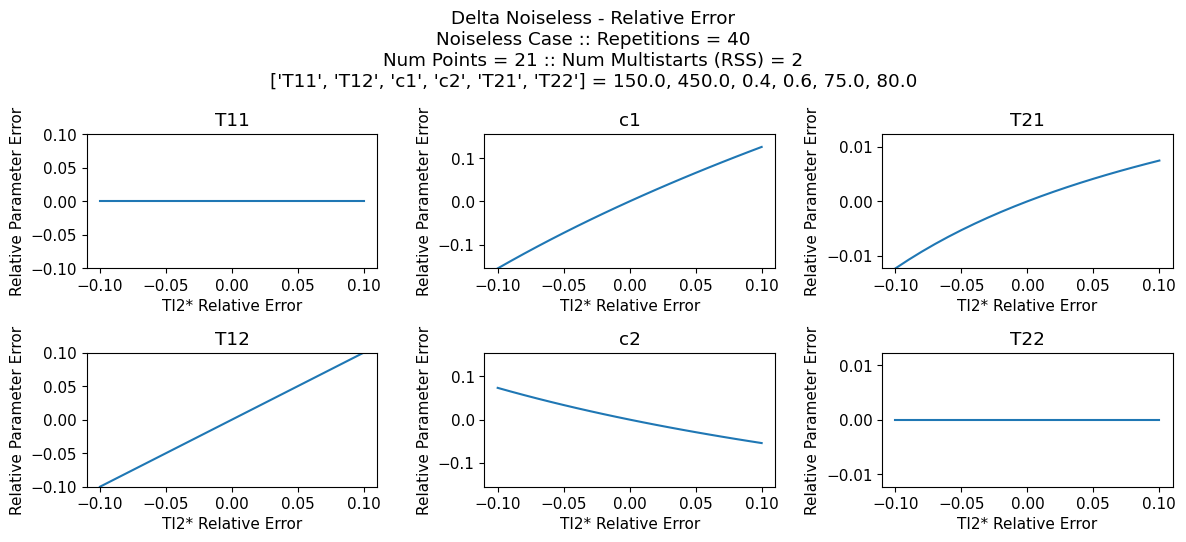

In [50]:
delta_NN_1p_var = np.var(delta_NN_1p, axis = -2)
delta_NN_1p_mean = np.mean(delta_NN_1p, axis = -2)
# delta_var_2p_bias = delta_var_2p_mean - true_params
delta_NN_1p_bias = np.mean(delta_NN_1p - true_params, axis = -2)
delta_NN_1p_MSE = delta_NN_1p_bias**2 + delta_NN_1p_var

delta_var_1p_CV1 = delta_NN_1p_var/delta_NN_1p_mean
delta_var_1p_CV2 = delta_NN_1p_var/true_params

#Relative Error
delta_NN_1p_RE = delta_NN_1p_bias/true_params

plt.rc('font', size  = 11)

# parameter_deltaPlot(delta_NN_range_rel, delta_var_1p_var, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)

# parameter_deltaPlot(delta_NN_range_rel, delta_var_1p_bias**2, param_list, "Delta Var - Square Bias", deets = details_delta_var)

# parameter_deltaPlot(delta_NN_range_rel, delta_NN_1p_MSE, "Delta Var - MSE", deets = details_delta_var)

parameter_deltaPlot(delta_NN_range_rel, delta_NN_1p_RE, param_list,"Delta Noiseless - Relative Error", deets = details_delta_NN, xlab = 'TI2* Relative Error', ylab = 'Relative Parameter Error', pos = False)


In [51]:
np.random.seed(7)

#NN for No Noise
delta_NN_2p = np.zeros((delta_NN_range_rel.shape[0], delta_NN_range_rel.shape[0], noisey_reps, 6))

for iDelt in trange(delta_NN_range_rel.shape[0]):
    for jDelt in range(delta_NN_range_rel.shape[0]):
        for iNR in range(noisey_reps):

            idelta_change = delta_NN_range_rel[iDelt]*TI1star
            jdelta_change = delta_NN_range_rel[jDelt]*TI2star
            T1_focus = TI1star+idelta_change
            T2_focus = TI2star+jdelta_change
            exact_data_np1 = S_biX_6p(TE_array, T1_focus, T11, T12, c1, c2, T21, T22)
            exact_data_np2 = S_biX_6p(TE_array, T2_focus, T11, T12, c1, c2, T21, T22)
            delta_NN_2p[iDelt,jDelt,iNR,:] = logical_estimation_curve(T1_focus, T2_focus, exact_data_np1, exact_data_np2)


100%|██████████| 21/21 [14:45<00:00, 42.15s/it]


Text(0, 0.5, 'Signal')

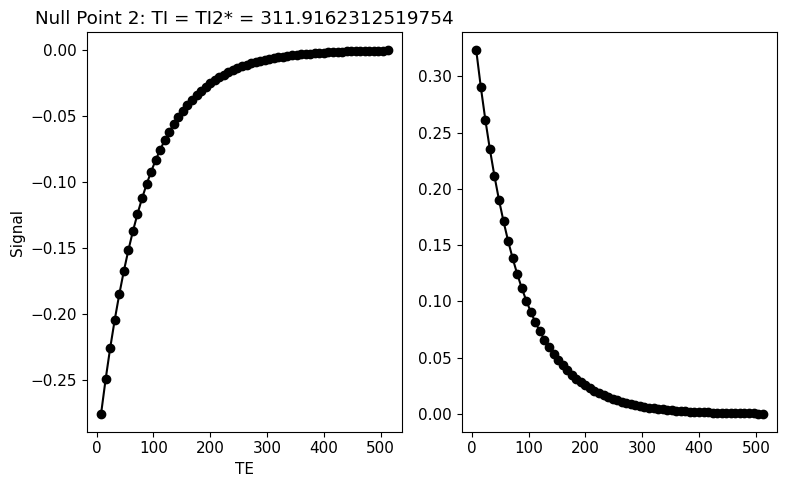

In [52]:
fig, ax = plt.subplots(1,2, figsize=(8,5), tight_layout=True)
ax[0].plot(TE_array, exact_data_np1, marker = 'o', color = 'k')
ax[0].set_title(f'Null Point 1: TI = TI1* = {TI1star}')
ax[0].set_xlabel('TE')
ax[0].set_ylabel('Signal')
ax[1].plot(TE_array, exact_data_np2, marker = 'o', color = 'k')
ax[0].set_title(f'Null Point 2: TI = TI2* = {TI2star}')
ax[0].set_xlabel('TE')
ax[0].set_ylabel('Signal')

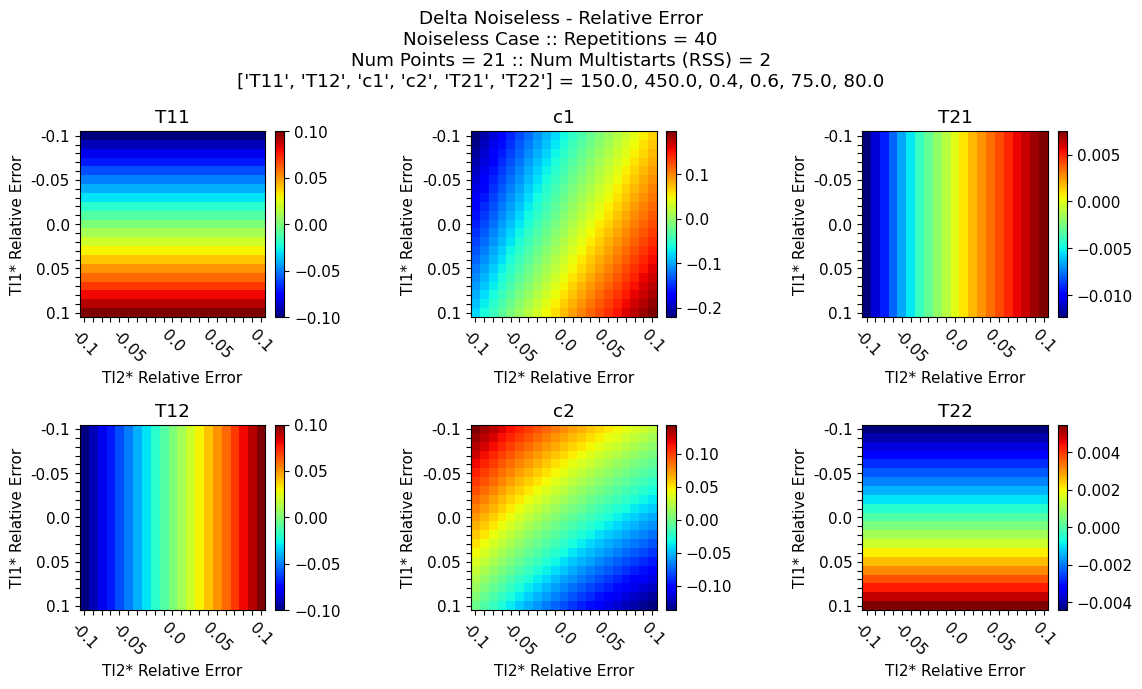

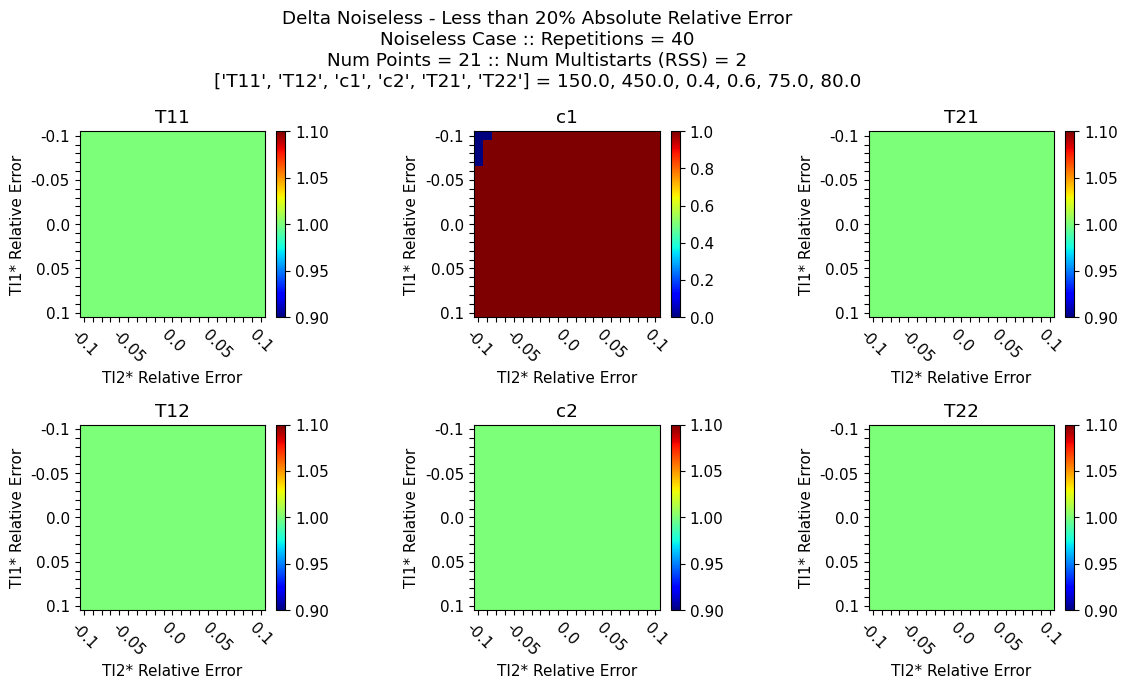

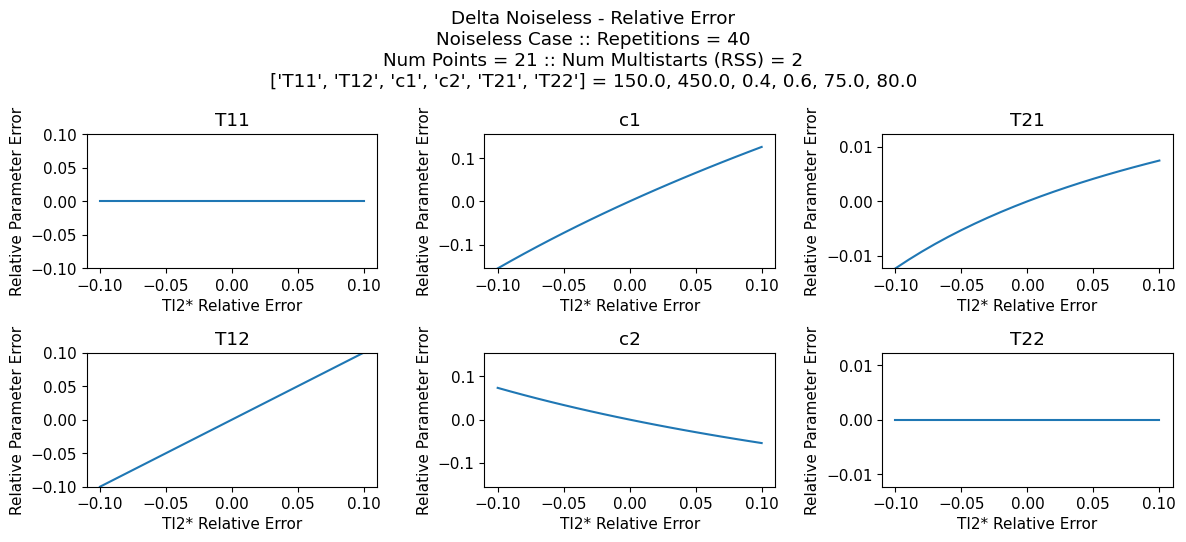

In [53]:
delta_NN_2p_var = np.var(delta_NN_2p, axis = -2)
delta_NN_2p_mean = np.mean(delta_NN_2p, axis = -2)
# delta_var_2p_bias = delta_var_2p_mean - true_params
delta_NN_2p_bias = np.mean(delta_NN_2p - true_params, axis = -2)
delta_NN_2p_MSE = delta_NN_2p_bias**2 + delta_NN_2p_var

delta_NN_2p_CV1 = delta_NN_2p_var/delta_NN_2p_mean
delta_NN_2p_CV2 = delta_NN_2p_var/true_params

#Relative Error
delta_NN_2p_RE = delta_NN_2p_bias/true_params

plt.rc('font', size  = 11)

# parameter_deltaPlot(delta_NN_range_rel, delta_var_1p_var, param_list, "Delta Var - Parameter Variance", deets = details_delta_var)

# parameter_deltaPlot(delta_NN_range_rel, delta_var_1p_bias**2, param_list, "Delta Var - Square Bias", deets = details_delta_var)

# parameter_deltaPlot(delta_NN_range_rel, delta_NN_1p_MSE, "Delta Var - MSE", deets = details_delta_var)

parameter_deltaPlot_2d(delta_NN_range_rel, delta_NN_2p_RE, param_list,"Delta Noiseless - Relative Error", deets = details_delta_NN, xlab = 'TI2* Relative Error', ylab = 'TI1* Relative Error', pos = False)

parameter_deltaPlot_2d(delta_NN_range_rel, np.abs(delta_NN_2p_RE)<0.20, param_list,"Delta Noiseless - Less than 20% Absolute Relative Error", deets = details_delta_NN, xlab = 'TI2* Relative Error', ylab = 'TI1* Relative Error', pos = False)

parameter_deltaPlot(delta_NN_range_rel, delta_NN_2p_RE[10,:], param_list,"Delta Noiseless - Relative Error", deets = details_delta_NN, xlab = 'TI2* Relative Error', ylab = 'Relative Parameter Error', pos = False)
